# Masking the Target
Let's experiment with several ways to isolate, or mask, the target in a sample image.

In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['image.cmap'] = 'gray'

We use OpenCV to open the file and load into a `numpy` array. OpenCV loads the array with pixels in BGR order so we need to convert to RGB for displaying using `matplotlib`.

## The Original Image

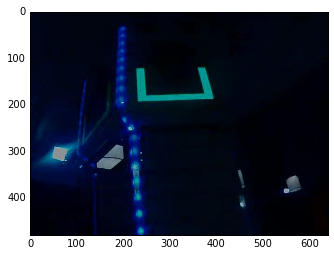

In [2]:
image = cv2.imread("../2016_RealFullField/15.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## Simple Thresholding
We start by applying [`cv2.GaussianBlur`](http://docs.opencv.org/2.4.13/modules/imgproc/doc/filtering.html?#gaussianblur) to reduce some of the high-frequency edges we are not interested in.

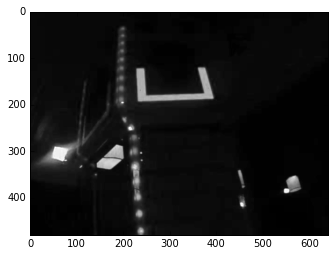

In [3]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(image, (5, 5), 0)
plt.imshow(blurred)
plt.show()

Applying simple thresholding requires us to select the threshold value, `T`, manually. All pixel values less than `T` are set to 0 and all pixels greater than `T` are set to 255.

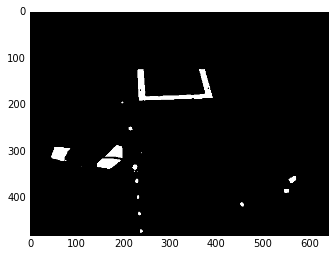

In [4]:
T = 99
(T, thresh) = cv2.threshold(blurred, T, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)
plt.show()